In [6]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from random import random
import json, os.path, pickle
import sys, time
from pathlib import Path
print(f"running python {sys.version}")

# condtional printing untility, only prints important messages
global verbosity
verbosity = 5
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)



running python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


Testing the learning curve mathematics based on three parameters.


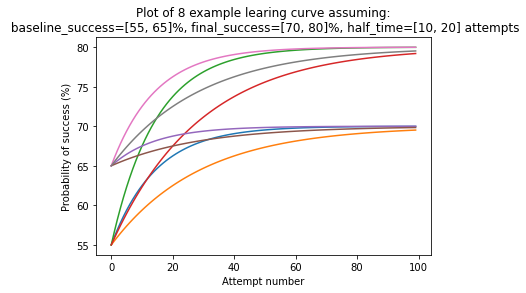

In [7]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

def plot_example_learning_curves():
    bs = [55, 65] # percent
    fs =[70,80] # percent
    ht = [10, 20]
    fig, ax = plt.subplots()
    for baseline_success in bs:
        for final_success in fs: # percent
            for half_time in ht: # cases
                x = np.array(range(0, 100))  
                y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
                plt.plot(x, y)  
    plt.title(f"Plot of {len(bs)*len(fs)*len(ht)} example learing curve assuming:\n baseline_success={bs}%, final_success={fs}%, half_time={ht} attempts")
    ax.set_ylabel('Probability of success (%)')
    ax.set_xlabel('Attempt number')
    plt.show()  

plot_example_learning_curves()

In [8]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 


"""
Make mock curves as defined by three lists of defining parameters:
* baseline success probablity (ie how well the student will do on first ever attempt)
* final sussess probability (ie how well this stuedent will eventually become)
* number of attempts to achieve half the improvement from baseline to final proficency
"""
def generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000):
    #baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
    baseline_success_p = np.random.beta(baseline_alpha, baseline_beta,n)
    failure_p = 1-baseline_success_p # baseline risk of failure 
    final_success_p = 1-(failure_p * (1-fall_in_failure_rate*np.random.random(n)))
    attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)
    return {"bsp": baseline_success_p, "fsp": final_success_p, "athi": attempts_to_half_improvement}

""" 
Describe a set of stuent curves, and optionally plot.
Return a dictionary of values.                      
"""
def describe_student_curves(sc, plots=False):
    print(f"""      
    baseline_success_p = {sc['bsp'].mean():0.2f} (sd: {sc['bsp'].std():0.2f})
    final_success_p = {sc['fsp'].mean():0.2f} (sd: {sc['fsp'].std():0.2f})
    attempts_to_half_improvement = {sc['athi'].mean():0.2f} (sd: {sc['athi'].std():0.2f})
    """)    
    if plots:
        n = len(sc['bsp'])
        count, bins, ignored = plt.hist(sc['bsp'], bins=100, density=True)
        plt.axis((0,1,0,n/200))
        plt.title("Distribution of student's baseline success p")
        plt.show()  
        count, bins, ignored = plt.hist(sc['fsp'], bins=100, density=True, range=(0,1))
        plt.title("Distribution of student's long-term success p")
        plt.axis((0,1,0,n/200))
        plt.show()  
        count, bins, ignored = plt.hist(sc['athi'], bins=100, density=False)
        plt.title("Distribution of student's attempts to make half ultimate improvement")
        plt.show()  
    return {
      "baseline_success_p": sc['bsp'].mean(),
      "baseline_success_p_sd": sc['bsp'].std(),     
      "final_success_p": sc['fsp'].mean(), 
      "final_success_p_sd": sc['fsp'].std(),
      "attempts_to_half_improvement": sc['athi'].mean(),
      "attempts_to_half_improvement_sd": sc['athi'].std(),
      "key": f"{sc['bsp'].mean():0.2f}_{sc['bsp'].std():0.2f}_{sc['fsp'].mean():0.2f}_{sc['fsp'].std():0.2f}_{sc['athi'].mean():0.2f}_{sc['athi'].std():0.2f}"
        }

""" 
Implement the student curve by calculating the probability of success at a given attempt. 
""" 
def student_p(student_id, attempt, sc):
    failure_risk = 0.5**(attempt/sc['athi'][student_id]) # in range 0 to 1
    return sc['fsp'][student_id] - failure_risk *(sc['fsp'][student_id] - sc['bsp'][student_id])
        
"""
create a 2d array of student success probabilities
"""
def student_attempt_success(sc, attempts=20):
    n = len(sc['bsp'])
    students = np.array(range(0, n))
    attempts = np.array(range(0, attempts))
    # make a matrix from the above two arrays
    return student_p(students[:,np.newaxis],attempts[np.newaxis,:],sc)    

def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

def create_mock_students(n = 2000, chattiness = 5):
    # baseline "beta" curve defining initial success rate
    baseline_alpha = 6
    baseline_beta = 8
    fall_in_failure_rate = .7 # how much do they improve (or does their failure rate drop)
    half_time_mean = 10 # how quickly to students learn?
    sc = generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n)
    sac = student_attempt_success(sc, attempts=20)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    return sc, sac

      
    baseline_success_p = 0.43 (sd: 0.13)
    final_success_p = 0.63 (sd: 0.15)
    attempts_to_half_improvement = 12.53 (sd: 6.47)
    


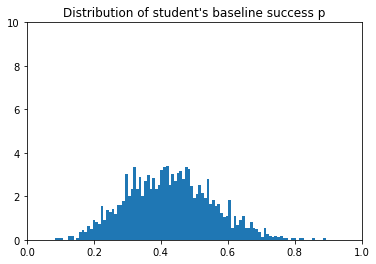

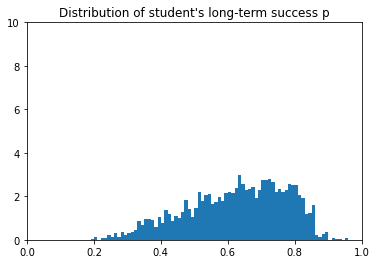

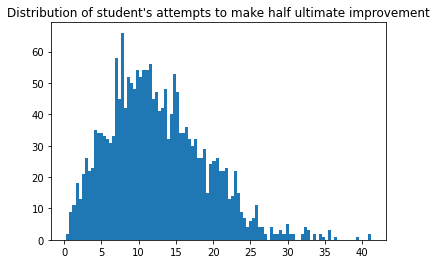

In [9]:
student_data_file = 'students0.43_0.13_0.63_0.15_12.53_6.47.pickle'

def read_student_data(student_data_file):
    with open(student_data_file, 'rb') as fp:
        data = pickle.load(fp)
        return data['sc'], data['sac']

if student_data_file:
    sc, sac = read_student_data(student_data_file)
    student_curve_attributes = describe_student_curves(sc, plots=True)
else:
    sc, sac, student_curve_attributes = create_mock_students(chattiness=10)   
    student_curve_attributes = describe_student_curves(sc, plots=True)
    student_curve_attributes['key']
    with open(f"students{student_curve_attributes['key']}.json", 'wb') as fp:
        pickle.dump({"sc":sc,"sac":sac}, fp)

In [10]:
def generate_trial_data(subject_n, attempt_n, trials, groups, sac):
    attempt_data = []
    participant_data = []
    trial_data = []
    totals = {}
    attempts_per_group = trials*subject_n*attempt_n
    print(f"{attempts_per_group} total attempts per group")
    for trial in range(trials):
        pp(7,f"=======\ntrial {trial}")
        for group, success_relative_increase in groups.items():
            pp(6, f"group: {group}")
            students = sac[np.random.choice(len(sac), subject_n, replace=True), :attempt_n]
            pp(5,students)
            result = succeeded(students,success_relative_increase)
            pp(6, f"result: {result}")
            pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
            totals[group] = totals.get(group, 0) + result.sum()
            rec = {'trial': trial, 'group': group, "result": result.sum()}
            trial_data.append(rec)
            for p in range(subject_n):
                participant_results = result[p]
                rec["p"] = f"{group}{p}"
                prec = {**rec, "result": participant_results.sum()}
                pp(1,prec)
                participant_data.append(prec)
                for i in range(len(participant_results)):
                    irec = {**rec, "pint": p, "i": i, "result": 1 if participant_results[i] else 0}
                    pp(1,irec)
                    attempt_data.append(irec)

    pp(5, f"totals: {totals}")
    td = pd.DataFrame(trial_data)
    partd = pd.DataFrame(participant_data)
    ad = pd.DataFrame(attempt_data)
    return td, partd, ad, totals

verbosity: 2
1000 trials sampling 5 for each of 5 groups out of 2000 students, each having 5 attempts
25000 total attempts per group
control 11447
interventionA 12537
interventionB 13496
interventionC 16541
nodif 11225
{'control': 45.788, 'interventionA': 50.148, 'interventionB': 53.984, 'interventionC': 66.164, 'nodif': 44.9}


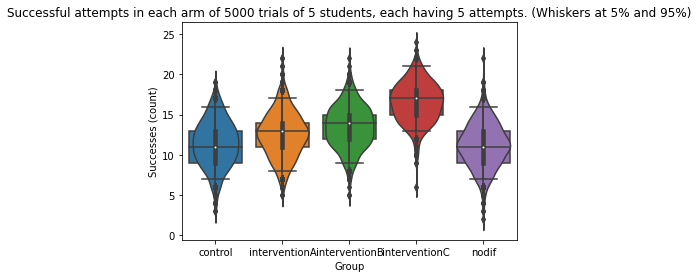

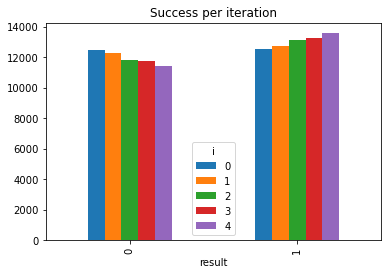

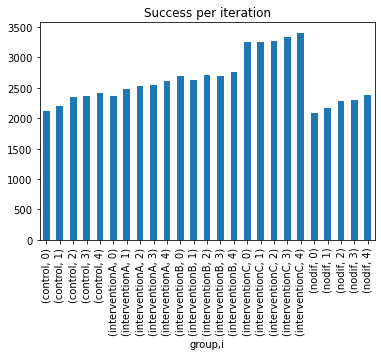

In [11]:
def trial_plots(td, partd, ad):
    whisker = 5
    ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
    #ax = sns.swarmplot(x="group", y="result", data=td)
    ax = sns.violinplot(x="group", y="result", data=td)
    ax.set_ylabel('Successes (count)')
    ax.set_xlabel('Group')

    plt.title(f"Successful attempts in each arm of {len(td)} trials of {int(len(partd)/len(td))} students, each having {int(len(ad)/len(partd))} attempts. (Whiskers at {whisker}% and {100-whisker}%)")
    plt.show()

    pd.crosstab(ad.result, ad.i).plot(kind='bar')
    plt.title("Success per iteration")
    plt.show()

    ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
    plt.title("Success per iteration")
    plt.show()
    
def test_trial_generation(sac, groups, subject_n = 5, attempt_n = 5, trials = 1000):
    global verbosity
    verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
    print(f"verbosity: {verbosity}")
    print(f"{trials} trials sampling {subject_n} for each of {len(groups)} groups out of {sac.shape[0]} students, each having {attempt_n} attempts")
    td, partd, ad, totals = generate_trial_data(subject_n, attempt_n, trials, groups, sac)

    def sumarise_trial(totals, attempts_per_group):
        results_percents = {}
        for group, result in totals.items():
            print(group, result)
            results_percents[group] = 100*result/attempts_per_group
        print(results_percents)
    sumarise_trial(totals, attempts_per_group=subject_n*attempt_n*trials)

    return td, partd, ad

groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "nodif": 0}
td, partd, ad = test_trial_generation(sac, groups)
trial_plots(td, partd, ad)

In [59]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.formula.api import gee

"""
see: https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html#CovStruct 
"""
def fit_models(ad, trials_to_test, tests):
    report_style = 'flat'
    outcomes = {}
    for trial in trials_to_test:
        if not trial % 100:
            print(">",end='')
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group")
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            if model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'ns' if p > 0.05 else 'wrong' if c['result'][0] > c['result'][1] else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            if report_style == 'flat':
                key = f"{model}{outcome}"
                if outcomes.get(key, -1) == -1:
                    outcomes.update({f"{model}wrong":0,f"{model}ns":0,f"{model}sig":0,f"{model}vsig":0})
                outcomes[key] += 1
            else:
                outcomes[model] = outcomes.get(model,{'wrong':0,'ns':0,'sig':0,'vsig':0})
                outcomes[model][outcome] = 1 + outcomes[model].get(outcome, 0)

    return(outcomes)


loading trial data from trial_cache1000


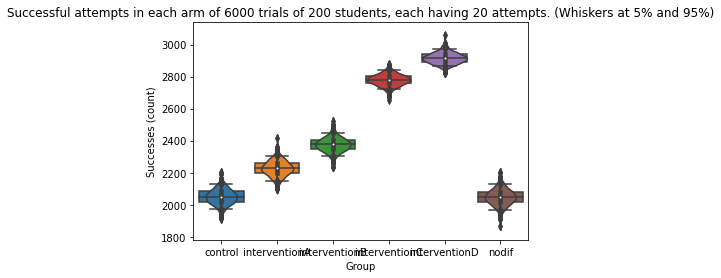

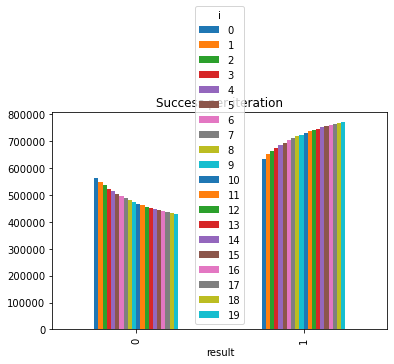

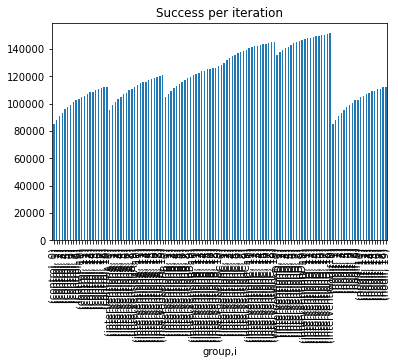

In [18]:
trial_cache_dir = "trial_cache1000"
if trial_cache_dir:
    print(f"loading trial data from {trial_cache_dir}")
    ad = pd.read_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd = pd.read_csv(f"{trial_cache_dir}/partd.csv")
    td = pd.read_csv(f"{trial_cache_dir}/td.csv")
else:
    print(f"generating fresh trial data")
    groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "interventionD": 0.8, "nodif": 0}
    td, partd, ad = test_trial_generation(groups, subject_n = 200, attempt_n = 20, trials = 1000, plots = True)
    
trial_plots(td, partd, ad)

In [60]:
def run_sym(attempt_data, pairs, tests, trials_to_test, spg, aps,
    run_key="A",cache_path="cache/"):
    print('.', end='')
    global verbosity
    verbosity = 6 if trials_to_test < 5 else 4
    Path(cache_path).mkdir(parents=True, exist_ok=True) # make the cache dir
    sym_results = []
    for comparision, pair in pairs.items():
        for students_per_group in spg: #[5, 10]:
            for attempts_per_student in aps: #[5,10]:
                # attempt to read from a cache file
                key = f"{run_key}.{trials_to_test}{comparision}.{students_per_group}.{attempts_per_student}"
                file = f"{cache_path}/{key}.json"
                if os.path.isfile(file):
                    with open(file) as f:
                        rec = json.load(f)
                    pp(8, f"loaded {file}")
                else:
                    query = f"group == {pair} and pint < {students_per_group} and i < {attempts_per_student}"
                    trial_data = ad.query(query)
                    pp(10, f"`{query}` ({len(trial_data)} total attempts)")
                    run_results = fit_models(ad=trial_data, trials_to_test=range(trials_to_test), tests=tests)
                    pp(10, f"run_results: {run_results}")
                    rec = {"comparision":comparision, 
                         "students_per_group": students_per_group, 
                         "attempts_per_student": attempts_per_student,
                         "groupA": pair[0], "groupB": pair[1], 
                         "total_attemps": len(trial_data),
                         **run_results,
                         'query': query, 'time':time.time()*1000,
                         'key': key}
                    with open(file, 'w') as f:
                        pp(8, f"saving {file}")
                        json.dump(rec, f)
                sym_results.append(rec)
    return pd.DataFrame(sym_results)

In [ ]:
def run_test(testing = True):
    pairs = {'none': ['control','nodif'],
                 'vsmall': ['control','interventionA'],
                 'small': ['control','interventionB'],
                 'big': ['control', 'interventionC'],
                 'huge': ['control', 'interventionD'],
                 'upper': [ 'interventionC', 'interventionD']
                }
    """
    {'control': 51.6145, 'interventionA': 55.88775, 'interventionB': 59.653125, 
    'interventionC': 69.713125, 'interventionD': 73.108, 'nodif': 51.515}    
    """
    if testing:
        students_per_group = [5, 10]
        attempts_per_student = [5,10,20]
        trials_to_test = 3
        cache = "cache_test/"
    else:
        students_per_group = [50] #[20, 30,50, 75, 100,200]
        attempts_per_student = [5, 10, 20]
        trials_to_test = 1000 # int(len(td)/len(groups)) #fixme 
        cache="cache1/"
        
    print(f"testing {trials_to_test} trials")
    return run_sym(
        attempt_data = ad,
        pairs = pairs,
        tests = ['geeBI'],
        trials_to_test = trials_to_test,
        spg = students_per_group,
        aps = attempts_per_student, 
        run_key="b",
        cache_path=cache
) 

#test3 = run_test(testing=True)
test4 = run_test(testing=False)

testing 1000 trials
.`group == ['control', 'nodif'] and pint < 50 and i < 5` (500000 total attempts)
>>>>>>>>>>run_results: {'geeBIwrong': 31, 'geeBIns': 945, 'geeBIsig': 14, 'geeBIvsig': 10}
saving cache1//b.1000none.50.5.json
`group == ['control', 'nodif'] and pint < 50 and i < 10` (1000000 total attempts)
>>>>>>>>>>run_results: {'geeBIwrong': 31, 'geeBIns': 940, 'geeBIsig': 22, 'geeBIvsig': 7}
saving cache1//b.1000none.50.10.json
`group == ['control', 'nodif'] and pint < 50 and i < 20` (2000000 total attempts)
>>>>>>>>>>run_results: {'geeBIwrong': 26, 'geeBIns': 946, 'geeBIsig': 25, 'geeBIvsig': 3}
saving cache1//b.1000none.50.20.json
`group == ['control', 'interventionA'] and pint < 50 and i < 5` (500000 total attempts)
>>>>>>>>>>run_results: {'geeBIwrong': 0, 'geeBIns': 818, 'geeBIsig': 113, 'geeBIvsig': 69}
saving cache1//b.1000vsmall.50.5.json
`group == ['control', 'interventionA'] and pint < 50 and i < 10` (1000000 total attempts)
>>>>>>>>>>run_results: {'geeBIwrong': 0, 'geeBI

In [21]:
#test2.to_csv("powertests5.csv")

In [22]:
test3


,comparision,students_per_group,attempts_per_student,groupA,groupB,total_attemps,geeBIwrong,geeBIns,geeBIsig,geeBIvsig,query,time,key
0,none,5,5,control,nodif,50000,0,3,0,0,"group == ['control', 'nodif'] and pint < 5 and...",1.626491e+12,b.3none.5.5
1,none,5,10,control,nodif,100000,0,3,0,0,"group == ['control', 'nodif'] and pint < 5 and...",1.626491e+12,b.3none.5.10
2,none,5,20,control,nodif,200000,0,3,0,0,"group == ['control', 'nodif'] and pint < 5 and...",1.626491e+12,b.3none.5.20
3,none,10,5,control,nodif,100000,0,3,0,0,"group == ['control', 'nodif'] and pint < 10 an...",1.626491e+12,b.3none.10.5
4,none,10,10,control,nodif,200000,0,3,0,0,"group == ['control', 'nodif'] and pint < 10 an...",1.626491e+12,b.3none.10.10
5,none,10,20,control,nodif,400000,0,3,0,0,"group == ['control', 'nodif'] and pint < 10 an...",1.626491e+12,b.3none.10.20
6,vsmall,5,5,control,interventionA,50000,0,3,0,0,"group == ['control', 'interventionA'] and pint...",1.626491e+12,b.3vsmall.5.5
7,vsmall,5,10,control,interventionA,100000,0,3,0,0,"group == ['control', 'interventionA'] and pint...",1.626491e+12,b.3vsmall.5.10
8,vsmall,5,20,control,interventionA,200000,0,3,0,0,"group == ['control', 'interventionA'] and pint...",1.626491e+12,b.3vsmall.5.20
9,vsmall,10,5,control,interventionA,100000,0,3,0,0,"group == ['control', 'interventionA'] and pint...",1.626491e+12,b.3vsmall.10.5
